# Logistic Regression with UCI Dataset

In [1]:

import os
os.environ["PYTHONWARNINGS"] = "ignore"

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import LabelEncoder
from ucimlrepo import fetch_ucirepo

from ld import LD, BP, get_eta

import itertools

In [2]:
def block_B(start_idx, end_idx):
    """
    Create a block B of indexes for the center region.

    Parameters:
    - start_idx: int, the starting index of the center region
    - end_idx: int, the ending index of the center region

    Returns:
    - center_region_indexes: numpy array with shape (n, 2), the indexes of the center region
    """
    # Create the index grid
    x, y = np.meshgrid(np.arange(start_idx, end_idx), np.arange(start_idx, end_idx))

    # Flatten the arrays and stack them as coordinate pairs
    center_region_indexes = np.column_stack((x.flatten(), y.flatten()))

    return center_region_indexes

In [3]:
def compute_Q(theta):
        r"""Compute decomposable tensor Q from parameter \theta using Dynamic Programming.

        Parameters
        ----------
        theta : array
            second/third-order tensor.
            Same shapes as input tensor P.

        beta : list
            sets of decomposition basis vectors.

        Returns
        -------
        Q : array
            second/third-order tensor.
            Decomposable tensor.
        """
        idx = theta.shape
        order = len(theta.shape)
        theta_sum = np.zeros(theta.shape)

        if order == 2:
            theta_sum[0, 0] = theta[0, 0]

            # update outside eta.
            for i in range(1, idx[0]):
                theta_sum[i, 0] = theta[i, 0] + theta_sum[i-1, 0]
            for j in range(1, idx[1]):
                theta_sum[0, j] = theta[0, j] + theta_sum[0, j-1]

            # update internal eta.
            for i in range(1, idx[0]):
                for j in range(1, idx[1]):
                    theta_sum[i, j] = theta[i, j] + theta_sum[i-1, j] \
                                        + theta_sum[i, j-1] - theta_sum[i-1, j-1]

        elif order == 3:
            theta_sum[0, 0, 0] = theta[0, 0, 0]

            # update outside eta.
            for i in range(1, idx[0]):
                theta_sum[i, 0, 0] = theta[i, 0, 0] + theta_sum[i-1, 0, 0]
            for j in range(1, idx[1]):
                theta_sum[0, j, 0] = theta[0, j, 0] + theta_sum[0, j-1, 0]
            for k in range(1, idx[2]):
                theta_sum[0, 0, k] = theta[0, 0, k] + theta_sum[0, 0, k-1]

            # update internal eta.
            for i, j in itertools.product(range(1, idx[0]), range(1, idx[1])):
                theta_sum[i, j, 0] = theta[i, j, 0] + theta_sum[i-1, j, 0] \
                                        + theta_sum[i, j-1, 0] - theta_sum[i-1, j-1, 0]
            for j, k in itertools.product(range(1, idx[1]), range(1, idx[2])):
                theta_sum[0, j, k] = theta[0, j, k] + theta_sum[0, j-1, k] \
                                        + theta_sum[0, j, k-1] - theta_sum[0, j-1, k-1]
            for i, k in itertools.product(range(1, idx[0]), range(1, idx[2])):
                theta_sum[i, 0, k] = theta[i, 0, k] + theta_sum[i-1, 0, k] \
                                        + theta_sum[i, 0, k-1] - theta_sum[i-1, 0, k-1]

            for i, j, k in itertools.product(range(1, idx[0]), range(1, idx[1]), range(1, idx[2])):
                theta_sum[i, j, k] = theta[i, j, k] + theta_sum[i-1, j, k] + theta_sum[i, j-1, k] \
                                    + theta_sum[i, j, k-1] - theta_sum[i-1, j-1, k] - theta_sum[i-1, j, k-1] \
                                    - theta_sum[i, j-1, k-1] + theta_sum[i-1, j-1, k-1]

        else:
            raise NotImplementedError("Order of input tensor should be 2 or 3. Order: {}.".format(order))

        Q = np.exp(theta_sum)
        psi = Q.sum()
        Q /= psi

        return Q

## Basic Logistic Regression

In [4]:
UCI_id = 856
test_size = 50

In [5]:
UCI_dataset = fetch_ucirepo(id=UCI_id)

X = np.array(UCI_dataset.data.features)
Y = np.array(LabelEncoder().fit_transform(UCI_dataset.data.targets))

# Print the shape of features and labels
print("Shape of features:", X.shape)
print("Shape of labels:", Y.shape)

# remove the last feature of X
X = X[:, :-1]
# Find unique labels
unique_labels = np.unique(Y)
print("Unique labels:", unique_labels)

# Create an array of indices
indices = np.arange(len(Y))
np.random.shuffle(indices)

# Use the shuffled indices to randomly select data for training and testing
n_train = len(Y) - test_size
X_train, Y_train = X[indices[:n_train]], Y[indices[:n_train]]
X_test, Y_test = X[indices[n_train:]], Y[indices[n_train:]]

print("Shape of features:", X_train.shape)

X_train_class = []
Y_train_class = []
for i in unique_labels:
    X_train_class.append(X_train[np.isin(Y_train, i).flatten()])
    Y_train_class.append(Y_train[np.isin(Y_train, i).flatten()])

Shape of features: (145, 31)
Shape of labels: (145,)
Unique labels: [0 1 2 3 4 5 6 7]
Shape of features: (95, 30)


Accuracy on the test set: 0.24


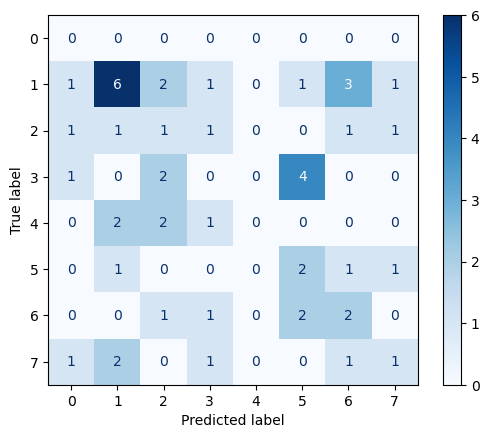

In [6]:
# Train a logistic classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, Y_train)

# Measure the accuracy on the test set
accuracy = clf.score(X_test, Y_test)
print("Accuracy on the test set:", accuracy)

# Optional: Display the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = clf.predict(X_test)
cm = confusion_matrix(Y_test, y_pred, labels=unique_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

## Data Generation

In [7]:
import cupy as cp

eta_hat_class = []

for X_train_per_class in X_train_class:
    eta_hat_list = []
    for i in range(X_train_per_class.shape[0]):
        x_tensor = X_train_per_class[i].reshape(2, 3, 5)
        D = len(x_tensor.shape)
        eps = np.asarray(1.0e-5)
        xp = cp.get_array_module(x_tensor)
        scaleX = xp.sum(x_tensor + eps)
        P = (x_tensor + eps) / scaleX
        eta_hat = get_eta(P, D, xp)
        eta_hat_list.append(eta_hat)
    eta_hat_class.append(cp.asarray(eta_hat_list))

# eta_hat_class_list_cp = cp.asarray(eta_hat_class_list)

In [8]:
# Do a linear approximate of the m-flat submanifold: compute the average eta_hat
avg_eta_hat_class = []

for eta_hat_list in eta_hat_class:
    mean = cp.mean(eta_hat_list, axis=0)
    avg_eta_hat_class.append(mean)

    # Compute RMSE (Relative Mean Squared Error)
    rmse = cp.sqrt(cp.mean((eta_hat_list - mean) ** 2)) / cp.sqrt(cp.mean(eta_hat_list ** 2))
    # Compute RAE (Relative Absolute Error)
    rae = cp.sum(cp.abs(eta_hat_list - mean)) / cp.sum(cp.abs(eta_hat_list))

    rmse_np = cp.asnumpy(rmse)
    rae_np = cp.asnumpy(rae)

    print("Relative Mean Squared Error (RMSE):", rmse_np)
    print("Relative Absolute Error (RAE):", rae_np)

Relative Mean Squared Error (RMSE): 0.08584130228164943
Relative Absolute Error (RAE): 0.08134332536810407
Relative Mean Squared Error (RMSE): 0.08189028619700787
Relative Absolute Error (RAE): 0.07705539999660267
Relative Mean Squared Error (RMSE): 0.08916441387332133
Relative Absolute Error (RAE): 0.08750120667234158
Relative Mean Squared Error (RMSE): 0.08628481450334413
Relative Absolute Error (RAE): 0.079326358554235
Relative Mean Squared Error (RMSE): 0.05581626504442302
Relative Absolute Error (RAE): 0.05161163927868421
Relative Mean Squared Error (RMSE): 0.0602911504868182
Relative Absolute Error (RAE): 0.055798850067670984
Relative Mean Squared Error (RMSE): 0.05813502274341172
Relative Absolute Error (RAE): 0.05470783027670504
Relative Mean Squared Error (RMSE): 0.07358828031415521
Relative Absolute Error (RAE): 0.0709991278354091


In [9]:
scaleX_class = []
Q_class = []
theta_class = []

for X_train_per_class in X_train_class:
    # Initialize lists to store the results
    scaleX_list = []
    Q_list = []
    theta_list = []

    # Initialize a list to store reconstructed images
    X_recons_list = []

    for x in X_train_per_class:
        x_tensor = x.reshape(2, 3, 5)
        _, scaleX, Q, theta = LD(x_tensor, order=2, verbose=False, n_iter=100, lr=1e-4, exit_abs=True)
        scaleX_list.append(scaleX)
        Q_list.append(Q)
        theta_list.append(theta)
        X_recons = (Q * scaleX).astype(np.int32)
        X_recons_list.append(X_recons)
    scaleX_class.append(scaleX_list)
    Q_class.append(Q_list)
    theta_class.append(theta_list)

In [10]:
# for i in unique_labels:
#     plt.figure(figsize=(16, 3))
#     for j in range(5):
#         plt.subplot(1, 5, j + 1)
#         plt.imshow(theta_class[i][j])
#         plt.axis('off')

#     plt.show()


### Backward Projection

In [11]:
B = block_B(2, 2)

avg_scaleX_class = []
P_BP_class = []
theta_BP_class = []
X_recons_class = []

for i in unique_labels:
    # Compute the avg_scaleX
    avg_scaleX = np.mean(scaleX_class[i], axis=0)

    P_list_BP = []
    theta_list_BP = []

    X_recons_list = []

    for j in range(X_train_class[i].shape[0]):
        # noisy_eta_hat = avg_eta_hat + np.random.normal(0, 1e-8, avg_eta_hat.shape)
        _, P, theta = BP(Q_class[i][j], theta_class[i][j], avg_eta_hat_class[i], avg_scaleX, order=1, verbose=False, n_iter=100, lr=1e-4, exit_abs=True)
        P_list_BP.append(P)
        theta_list_BP.append(theta)

        X_recons = (P).astype(np.int32)
        X_recons_list.append(X_recons)

    avg_scaleX_class.append(avg_scaleX)
    P_BP_class.append(P_list_BP)
    theta_BP_class.append(theta_list_BP)
    X_recons_class.append(X_recons_list)

In [12]:
# for i in unique_labels:
#     plt.figure(figsize=(16, 3))
#     for j in range(5):
#         plt.subplot(1, 5, j + 1)
#         plt.imshow(theta_BP_class[i][j])
#         plt.axis('off')

#     plt.show()

### Fitting and Sampling

In [13]:
num_new_samples = 30

sampled_Q_class = []
sampled_theta_class = []
for i in unique_labels:
    theta_BP = np.array(theta_BP_class[i]).reshape(-1, 5*6)
    # Compute mean and covariance matrix
    mean_theta = np.mean(theta_BP, axis=0)
    cov_theta = np.cov(theta_BP, rowvar=False)

    # Sample new data from the Gaussian distribution
    sampled_theta = np.random.multivariate_normal(mean_theta, cov_theta, num_new_samples).reshape(num_new_samples, 2, 3, 5)

    # plt.figure(figsize=(16, 3))
    # for j in range(5):
    #     plt.subplot(1, 5, j + 1)
    #     plt.imshow(sampled_theta[j].reshape(2, 3, 5))
    #     plt.axis('off')
    # plt.show()

    # Assuming a function compute_Q exists
    sampled_Q = []
    for j in range(num_new_samples):
        sampled_Q.append(compute_Q(sampled_theta[j]))

    sampled_theta_class.append(sampled_theta)
    sampled_Q_class.append(sampled_Q)

In [14]:
# Compute the avg_scaleX
sampled_P_BP_class = []
sampled_theta_BP_class = []
X_recons_class = []

for i in unique_labels:
    sampled_P_list_BP = []
    sampled_theta_list_BP = []
    X_recons_list = []
    for j in range(num_new_samples):
        # add noise to eta_hat
        _, P, theta = BP(sampled_Q_class[i][j], sampled_theta_class[i][j], avg_eta_hat_class[i], avg_scaleX_class[i], order=1, verbose=False, n_iter=100, lr=1e-4, exit_abs=True)
        sampled_P_list_BP.append(P)
        sampled_theta_list_BP.append(theta)

        X_recons = (P).astype(np.int32).reshape(-1)
        X_recons_list.append(X_recons)

    sampled_P_BP_class.append(sampled_P_list_BP)
    sampled_theta_BP_class.append(sampled_theta_list_BP)
    X_recons_class.append(np.array(X_recons_list))

In [15]:
for i in unique_labels:
    X_train_new = np.concatenate((X_train, X_recons_class[i]), axis=0)
    Y_train_new = np.concatenate((Y_train, np.array([i] * num_new_samples)), axis=0)

Accuracy on the test set: 0.22


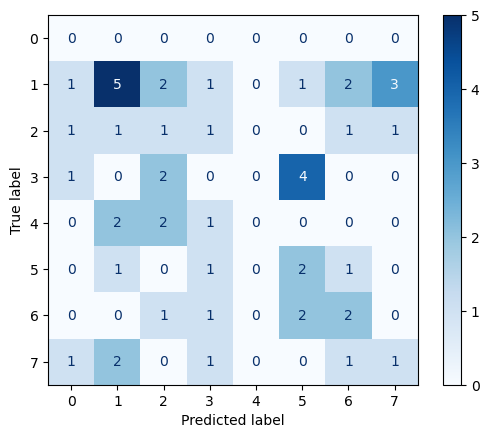

In [16]:
# Train a logistic classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_new, Y_train_new)

# Measure the accuracy on the test set
accuracy = clf.score(X_test, Y_test)
print("Accuracy on the test set:", accuracy)

# Optional: Display the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = clf.predict(X_test)
cm = confusion_matrix(Y_test, y_pred, labels=unique_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()